In [1]:
import tensorflow as tf
import pandas as pd
import datetime as dt
import quandl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
quandl.ApiConfig.api_key = 'VMzrqquNfHGPbXAMKWGh'

In [2]:
TCS_df = pd.read_csv('TCS')
p = TCS_df['Close'].as_matrix()
l = []

In [3]:
tf.reset_default_graph()

In [4]:
n = len(p)
ts = 100#time steps
m = 10#no of price ticks[inputs]
c = 1 #transaction cost
batch_size = 1
#features shape - (m*1)
#W - shape(m*1)
#U - shape(1*1)

In [5]:
z = np.array([p[i+1] - p[i] for i in range(n-1)])
z = z.reshape([n-1,1])
decisions = np.array([1,0,-1])

In [6]:
def next_batch(t):
    l1 = t
    
    l2 = t+m+ts
    
    return z[l1:l2]

In [7]:
def init_weights(shape):
    rn = tf.random_normal(shape)
    return tf.Variable(rn)
    

In [8]:
def inp_layer(x,W,b):
    return tf.matmul(tf.transpose(W),x) + b
    

In [9]:
def out_inp_layer(d,U):
    return tf.matmul(tf.transpose(U),d)

In [10]:
def output(x,y):
    return tf.tanh(x+y)

In [11]:
def forward_prop(ft,dt,W,b,U):
    i1 = inp_layer(ft,W,b)
    i2 = out_inp_layer(dt,U)
    o = output(i1,i2)
    return o

In [12]:
def unfolded(features,W,b,U,dt):
    delta = [dt]
    r = []
    for i in range(1,ts+1):
        f = tf.slice(features,[i-1,0],[m,1])
        l.append(f)
        delta.append(forward_prop(f,delta[i-1],W,b,U))
        Rt = delta[i-1]*z[i-1] - c*tf.abs(delta[i] - delta[i-1])
        r.append(Rt)
    UT = sum(r)
    return UT,r,delta

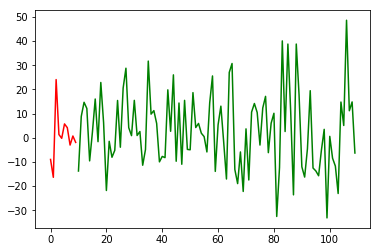

In [25]:
#def dnn_layer(features)
plt.plot([i for i in range(m)],z[0:m],'r')
plt.plot([i for i in range(m,m+ts)],z[m:m+ts],'g')

In [14]:
obj = []
learning_rate = 0.01

In [18]:
W = init_weights([m,1])
U = init_weights([1,1])
b = init_weights([1,1])
#dt = tf.placeholder(tf.float32,shape = [1,1])
dt = tf.Variable(tf.zeros([1,1]),dtype=tf.float32,trainable=False)
features = tf.placeholder(tf.float32,shape = [m+ts,1])
UT,r,delta = unfolded(features,W,b,U,dt)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(-UT)

In [19]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()
steps = 1
epochs = 2000
with tf.Session() as sess:
    sess.run(init)
    for j in range(epochs):
        ind = 0
        for i in range(steps):
            #print(ind)
            x_curr = next_batch(ind)
            #_,val,delt,d = sess.run([train,UT,delta,dt],feed_dict = {features:x_curr.reshape([10,1])})
            _,val,delt,w = sess.run([train,UT,delta,W],feed_dict = {features:x_curr.reshape([m+ts,1])})
            obj.append(val[0][0])
            ind = ind + m+ts
    print(val)
    saver.save(sess, "./stock")
    
    

[[ 641.15380859]]


In [17]:
len(z[0:ts])

100

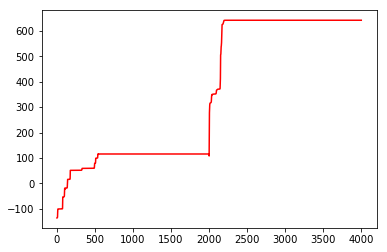

In [27]:
plt.plot(obj,'r')